In [1]:
pip install split-folders


You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


In [3]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(38,activation='softmax')(x) #final layer with softmax activation

17227776/17225924 [==============================] - 0s 0us/step


In [4]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [5]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [6]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio('../input/plantvillage-dataset/segmented', output="output", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 54306 files [04:44, 190.56 files/s]


In [7]:

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('./output/train', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 43430 images belonging to 38 classes.


In [8]:
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=train_datagen.flow_from_directory('./output/val', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 10876 images belonging to 38 classes.


In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
accident_model=model.fit_generator(generator=train_generator,
                    validation_data =val_generator,
                   steps_per_epoch= step_size_train//50,
                      
                  epochs = 5,                 
    )


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
27/27 [==============================] - 298s 11s/step - loss: 2.8526 - accuracy: 0.3063 - val_loss: 5.6314 - val_accuracy: 0.2717
Epoch 2/5
27/27 [==============================] - 292s 11s/step - loss: 1.3534 - accuracy: 0.6405 - val_loss: 2.0686 - val_accuracy: 0.4851
Epoch 3/5
27/27 [==============================] - 294s 11s/step - loss: 0.8696 - accuracy: 0.7158 - val_loss: 2.8313 - val_accuracy: 0.3803
Epoch 4/5
27/27 [==============================] - 294s 11s/step - loss: 0.8622 - accuracy: 0.7460 - val_loss: 1.6161 - val_accuracy: 0.6022
Epoch 5/5
27/27 [==============================] - 294s 11s/step - loss: 0.8039 - accuracy: 0.7743 - val_loss: 6.9917 - val_accuracy: 0.3003


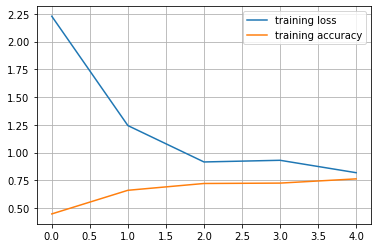

In [10]:
plt.plot(accident_model.history['loss'], label = 'training loss')
plt.plot(accident_model.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

In [11]:
from keras.models import load_model 
model.save("network.h5") 

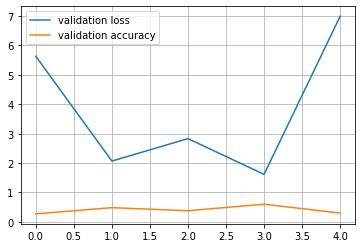

In [12]:
plt.plot(accident_model.history['val_loss'], label = 'validation loss')
plt.plot(accident_model.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [13]:
from keras.models import load_model 


In [14]:
model = load_model('network.h5')
# summarize model.
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

In [15]:
print("Calculating Model Accuracy....")
accuracy_score = model.evaluate(val_generator)
print(f"Accuracy: {accuracy_score[1]*100}")

Calculating Model Accuracy....
340/340 [==============================] - 235s 690ms/step - loss: 6.9917 - accuracy: 0.3003
Accuracy: 30.02942204475403


In [16]:
from keras.models import load_model 
model.save("network.h5") 

In [17]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
import pickle

In [18]:
Img_size = 256
clas = ['early_blight','healthy','late_blight']

In [19]:
def cal_per(pth):
    if type(pth)== str:
        img_array = cv2.imread(pth, cv2.IMREAD_COLOR)
        new_img = cv2.resize(img_array, (Img_size,Img_size))
        gray = rgb2gray(new_img)
    else: 
        gray = rgb2gray(pth)
    gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
    for i in range(gray_r.shape[0]):
        if gray_r[i] > gray_r.mean():
            gray_r[i] = 255
        elif gray_r[i] > 0.5:
            gray_r[i] = 255
        elif gray_r[i] > 0.25:
            gray_r[i] = 0
        else:
            gray_r[i] = 0
    gray = gray_r.reshape(gray.shape[0],gray.shape[1])
    plt.imshow(gray, cmap='gray')
    x1 = 0
    gr = gray.reshape(-1)
    for i in range(gray.shape[0]*gray.shape[1]):
        if gr[i] != 0:
            x1+= 1
    y1=gray.shape[0]*gray.shape[1]  
    z = (y1-x1)/y1
    print("percent of infected part is ", z*100, "%")
    if z <0.3:
        print("Severity stage is 1 and yeild is" , 95 - z*100, "%")
    elif z<0.6 and z >= 0.3:
        print("Severity stage is 2 and yeild is" , 95 - z*100, "%")
    else:
        print("Severity stage is 3 and yeild is" , 95 - z*100, "%")
       

percent of infected part is  58.03680419921875 %
Severity stage is 2 and yeild is 36.96319580078125 %


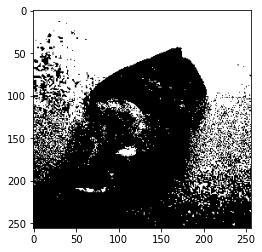

In [20]:
cal_per('../input/plantvillage-dataset/grayscale/Potato___Late_blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG')

percent of infected part is  47.16796875 %
Severity stage is 2 and yeild is 47.83203125 %


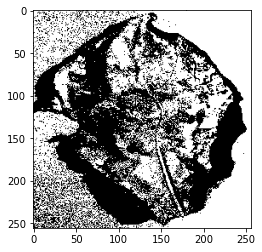

In [21]:
cal_per('../input/plantvillage-dataset/grayscale/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG')